# Customer Personality Analysis Project Report

## 1. Problem and Data Overview

In today's highly competitive market, understanding customer consumption behavior is crucial. The goal of this project is to analyze customer spending patterns through clustering analysis, enabling businesses to formulate more targeted marketing strategies. For this purpose, we use the "Customer Personality Analysis" dataset from Kaggle.

The dataset contains 2,240 records and 29 features, covering customers' basic information (such as age, education level, marital status, and income) as well as their consumption behavior (such as purchase frequency, total spending, and recent purchase time).

## 2. Exploratory Data Analysis (EDA)

### Data Inspection and Visualization
1. **Age Distribution**: Customer ages are mainly concentrated between 30-70 years old.
2. **Education Distribution**: Primarily consists of "Graduation," "Master's," and "PhD" categories.
3. **Marital Status Distribution**: Mainly includes "Married," "Single," and "Together."
4. **Income Distribution**: The data contains outliers that need to be cleaned.

### Data Cleaning
- Handling missing values by filling in appropriate data.
- Removing outliers in income and age to ensure reliable analysis results.
- Calculating the correlation of each feature with the target variable, ultimately selecting the 11 most relevant features for model training:
  - `Education`, `Marital_Status`, `Income`, `Kids`, `CustomerDays`, `Recency`, `TotalAmount`, `TotalNumPurchases`, `TotalAcceptedCmp`, `Complain`, `Response`

## 3. Model Architecture

This project uses three clustering methods for customer segmentation:

1. **K-Means Clustering**
   - Suitable for large-scale datasets with efficient computation.
   - Requires pre-specifying the number of clusters.

2. **DBSCAN Clustering**
   - Can identify noise points and automatically determine the number of clusters.
   - Works well for unevenly distributed data but performs poorly on high-dimensional data.

3. **Optimized K-Means Clustering**
   - Used PCA for dimensionality reduction, selecting "TotalAmount," "Income," and "TotalNumPurchases" as key features.
   - Tuned hyperparameters to improve clustering performance.

### Hyperparameter Tuning
- **K-Means**: Adjusting the `k` value to optimize the silhouette coefficient.
- **DBSCAN**: Adjusting `eps` and `min_samples` to enhance clustering results.
- **PCA**: Selecting the most representative features to improve computational efficiency.

## 4. Results and Analysis

| Model | Silhouette Coefficient |
|------|--------------------|
| K-Means | 0.310 |
| DBSCAN | 0.361 |
| Optimized K-Means | 0.445 |

The optimized K-Means achieved the best clustering performance, primarily because PCA improved the separation of clusters and an appropriate `k` value optimized cluster division.

### Identified Customer Segments:
1. **Moderate Income, Moderate Spending**
   - Customers in this segment have balanced income and spending behavior.
   - This is the largest group, representing typical spending patterns.

2. **Low Income, Low Spending**
   - These customers have lower income and spend less.
   - Likely to be more financially conservative due to limited financial resources.

3. **High Income, Low Spending**
   - These customers have high income but low spending.
   - They may prioritize saving over spending or adopt a conservative approach to expenses.

## 5. Conclusion

### Key Takeaways
- EDA helped uncover major customer spending patterns.
- Comparison of different clustering methods showed that the optimized K-Means performed best in this project.
- PCA improved computational efficiency and clustering quality.

### Future Improvements
- Explore more advanced clustering algorithms such as Gaussian Mixture Model (GMM) or hierarchical clustering.
- Enhance feature engineering to discover more variables influencing consumption behavior.
- Combine with supervised learning methods to further refine customer profiling.

The findings of this project provide valuable insights for marketing strategies, helping businesses better target their customers.



# Import

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, make_scorer
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-personality-analysis/marketing_campaign.csv


# Data loading and displaying

In [96]:
df = pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv',sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [97]:
# Shape of the dataset
df.shape

(2240, 29)

In [98]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# EDA

In [99]:
# Check for duplicates
df.duplicated().sum()

0

In [100]:
# Check for missing values
print(df.isnull().sum()[df.isnull().sum()>0])

Income    24
dtype: int64


In [101]:
# Drop the null values
df = df.dropna()
print(f"Missing values in data: {df.isnull().sum().sum()}")

Missing values in data: 0


In [102]:
def plot_histogram(data, title, xlabel, ylabel, bins=20, color_palette="rocket_r"):
    """
    General histogram drawing function (for continuous data, such as age distribution)
    """
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    n, bins, patches = plt.hist(data, bins=20, edgecolor='black', alpha=0.8)
    colors = sns.color_palette(color_palette, len(patches))
    for patch, color, count in zip(patches, colors, n):
        patch.set_facecolor(color)
        if count > 0:
            plt.text(patch.get_x() + patch.get_width() / 2, count, int(count), 
                     ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


def plot_bar_chart(data, title, xlabel, ylabel, color_palette="mako_r"):
    """
    General bar plot function (for discrete categorical data)
    """
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    
    colors = sns.color_palette(color_palette, len(data))
    bars = plt.bar(data.index, data.values, color=colors, edgecolor='black', alpha=0.85)
    
    for bar, count in zip(bars, data.values):
        plt.text(bar.get_x() + bar.get_width() / 2, count, f'{count}', 
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(title, fontsize=16, fontweight='bold', pad=15)
    plt.xlabel(xlabel, fontsize=14, labelpad=10)
    plt.ylabel(ylabel, fontsize=14, labelpad=10)
    plt.xticks(fontsize=12, rotation=15) 
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


def plot_pie_chart(xdata, ydata, title, xlabel, ylabel):
    """
    Generic pie chart drawing functions
    """
    data = {
        xlabel: xdata,
        ylabel: ydata
    }
    # Plotly Donut Chart with labels outside
    fig = px.pie(data, 
                 names=xlabel, 
                 values=ylabel, 
                 title=title,
                 color_discrete_sequence=px.colors.sequential.Reds)
    fig.update_traces(hole=0.4, textinfo='percent', textposition='outside', textfont_size=12)
    fig.update_layout(title_font_size=14)
    fig.show()


def plot_histogram2(df, numerical_cols):
    """Plot histograms for numerical features to visualize their distributions."""
    num_plots = len(numerical_cols)
    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(numerical_cols):
        sns.histplot(df[col], kde=False, bins=30, color='skyblue', edgecolor='black', ax=axes[i])
        axes[i].set_title(f"Histogram of {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Frequency")
    
    for i in range(num_plots, len(axes)):
        axes[i].axis('off') 
    plt.tight_layout()
    plt.show()


def plot_boxplot2(df, numerical_cols):
    """Plot boxplots for numerical features to visualize the distribution and detect outliers."""
    num_plots = len(numerical_cols)
    num_rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)
    
    fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))
    axes = axes.flatten() 
    
    for i, col in enumerate(numerical_cols):
        sns.boxplot(x=df[col], color='lightgreen', ax=axes[i])
        axes[i].set_title(f"Boxplot of {col}")
        axes[i].set_xlabel(col)
    
    for i in range(num_plots, len(axes)):
        axes[i].axis('off') 
    
    plt.tight_layout()
    plt.show()

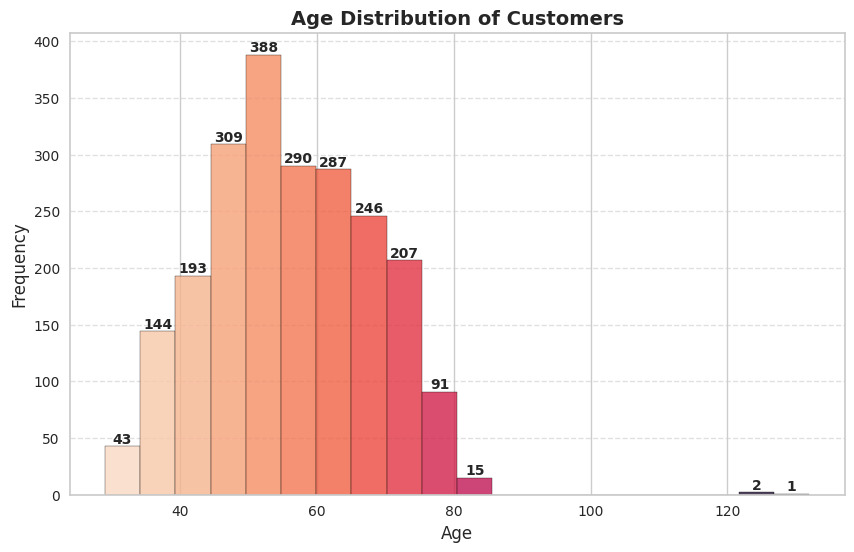

In [103]:
# Calculating age
df['Age'] = datetime.now().year - df['Year_Birth']

plot_histogram(df['Age'], 
               title='Age Distribution of Customers', 
               xlabel='Age', 
               ylabel='Frequency')

#### Observations
Core demographic (50-60 years old), this age group forms the largest customer base, suggesting that the product/service may appeal most to the middle aged. After the age of 60, the number of customers gradually decreases with the increase of age, indicating that the participation of the elderly is reduced. People in the 30-40 age group may have different needs and preferences that can foster their long-term loyalty. Although the numbers decrease with age, there is still a significant segment between 60 and 80 years old, suggesting that targeted services for the elderly may be beneficial. Few clients were over 90 years old, which may indicate limited participation by extremely older people.

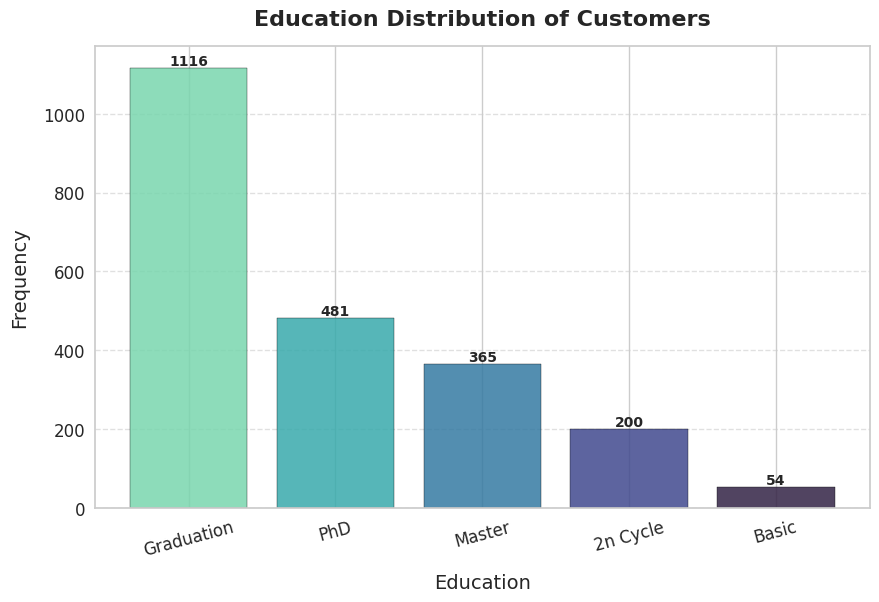

In [104]:
# Calculate the number of each education level
education_counts = df['Education'].value_counts()

plot_bar_chart(education_counts, 
               title='Education Distribution of Customers', 
               xlabel='Education', 
               ylabel='Frequency')

#### Observations
The majority of customers have at least postgraduate level education, indicating that the customer base is highly educated and the fraction of customers with only basic education is much smaller, indicating that the market is dominated by a higher education population and strategies can be developed to attract customers with higher education background as they are the majority

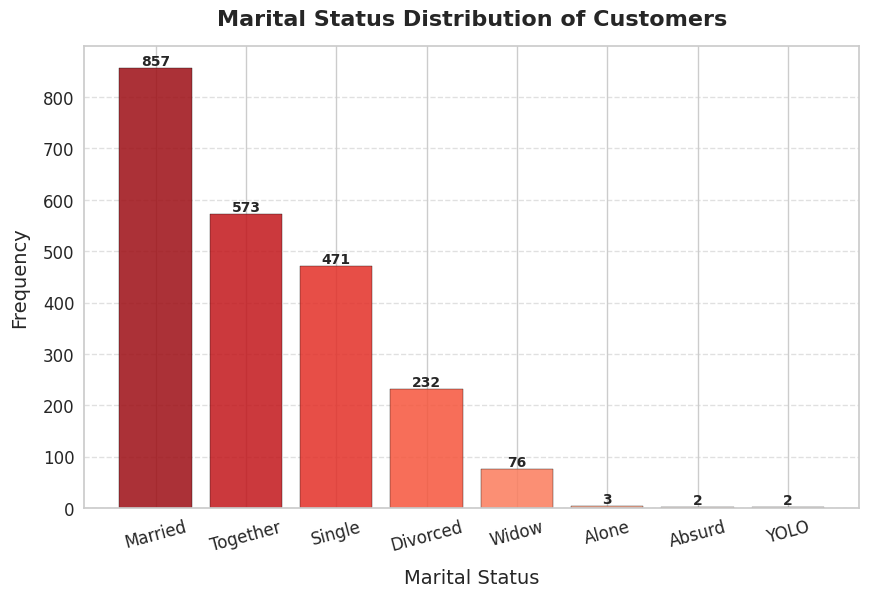

In [105]:
# Calculate the distribution of the number of marital status
marital_counts = df['Marital_Status'].value_counts()

plot_bar_chart(marital_counts, 
               title='Marital Status Distribution of Customers', 
               xlabel='Marital Status', 
               ylabel='Frequency',
               color_palette="Reds_r")

#### Observations
The two categories married and couples constitute the majority and may indicate a preference for products/services that are attractive to partnered individuals. Singles and divorces, while smaller in number, still represent a sizable market segment that can be targeted with specific marketing strategies. Categories like "Absurd" and "YOLO" may need to be reviewed for data quality or validation purposes.

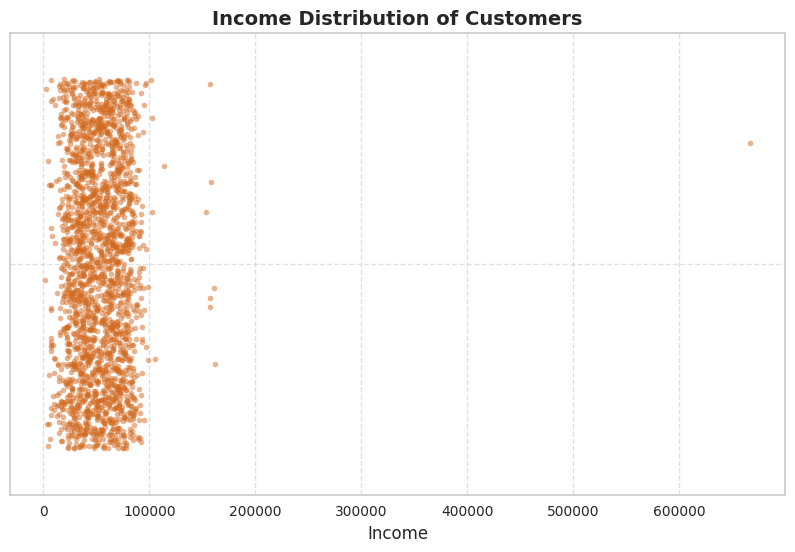

In [106]:
# The income distribution is calculated and checked for the presence of abnormal data
plt.figure(figsize=(10, 6))
sns.stripplot(x=df['Income'], color="chocolate", alpha=0.5, jitter=0.4, size=4)

plt.title('Income Distribution of Customers', fontsize=14, fontweight='bold')
plt.xlabel('Income', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

#### Observations
Customers with income below 100,000 are the largest group, high income potential: a small number of representatives from high income customers indicate room for growth and high income outliers can be removed.

In [107]:
# 按购买方式分布
p_columns = ['NumDealsPurchases', 'NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
plot_pie_chart(p_columns, 
               df[p_columns].sum(), 
               'Distribution of purchases', 
               'Category', 
               'Total Spending')

#### Observations
Brick-and-mortar stores account for the highest proportion of purchases, indicating that customers prefer to shop at brick-and-mortar stores. High web access rates indicate online engagement, but the gap with online purchases indicates that there is room for improvement in online conversion rates. The smallest portion of purchases comes from transactions, possibly indicating that customers are less affected by discounts, or that there are fewer promotional deals.

In [108]:
# Distribution of product sales by category
p_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
plot_pie_chart(p_columns, 
               df[p_columns].sum(), 
               'Distribution of product categories', 
               'Category', 
               'Total Spending')

#### Observations
Wine products account for more than half of the total consumption, indicating that customers have a strong preference or demand for this product category. Fruit and food accounted for the smallest proportion of expenditure, which may indicate less demand for these items. Meat products are an important part of consumption, so promotions or targeted campaigns in this area may be effective. High value products have a reasonable share, indicating that customers are interested in quality products.

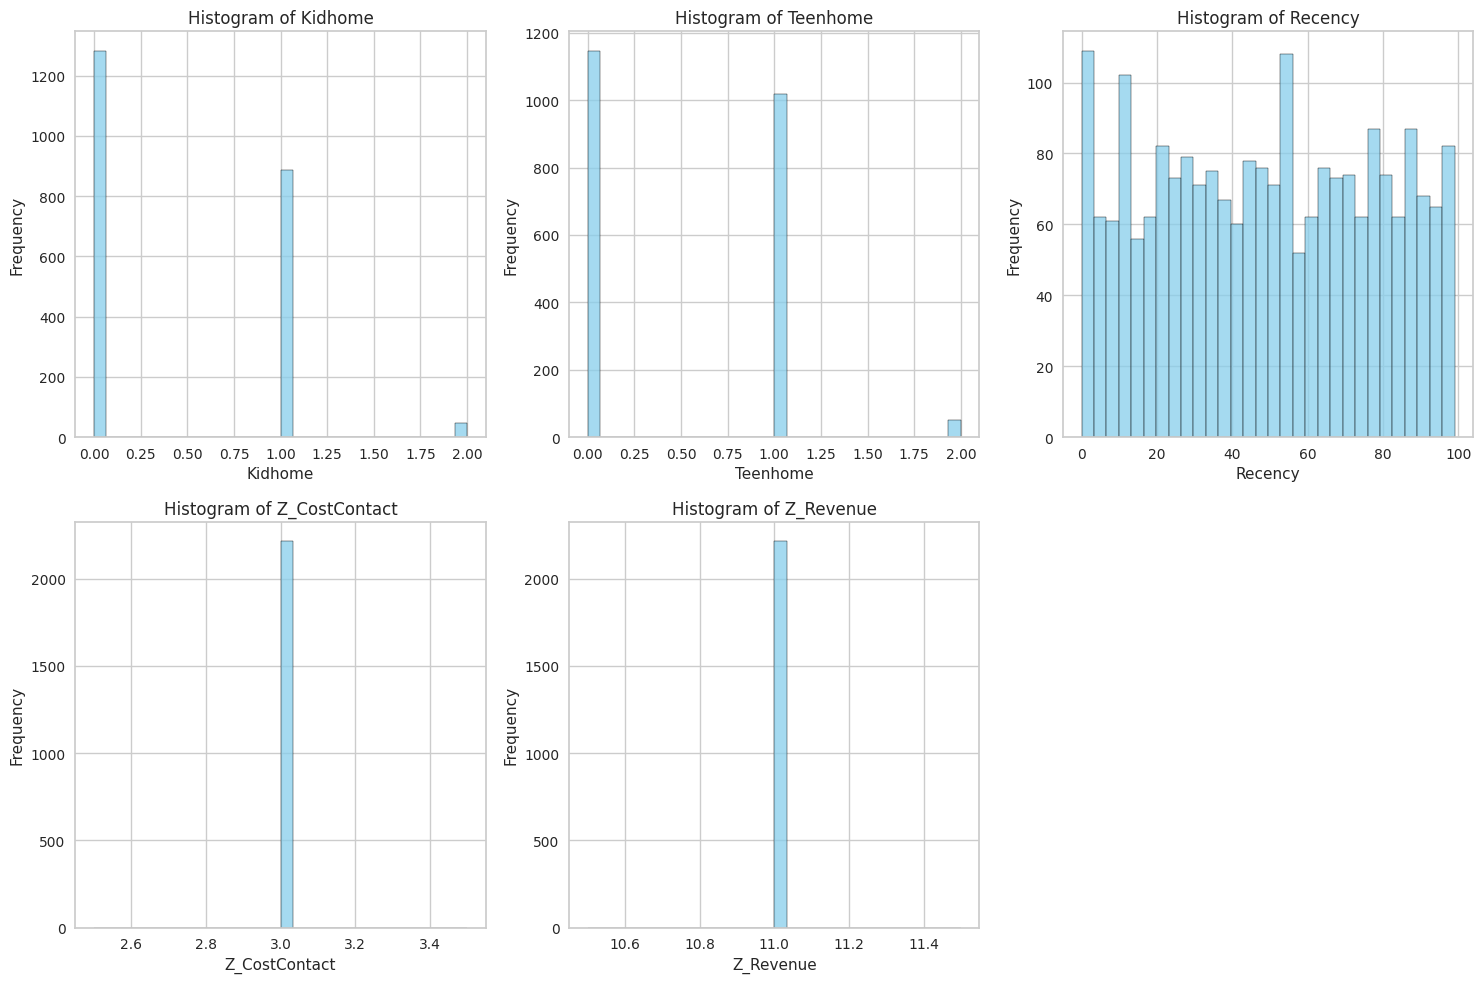

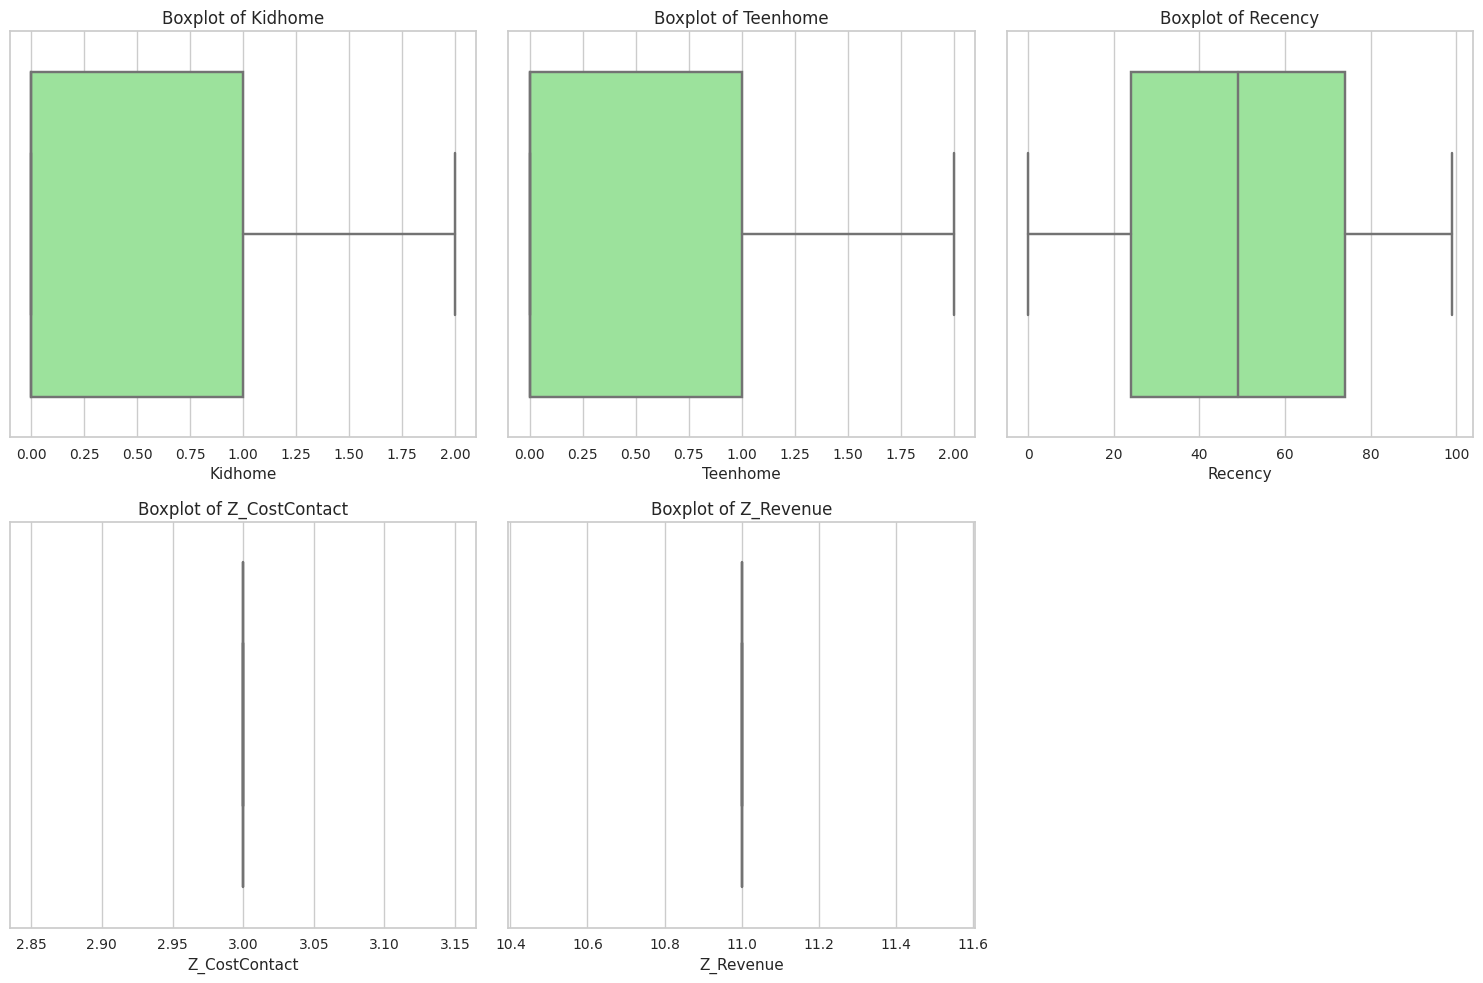

In [109]:
# Other data probes, focusing on the presence of data anomalies
o_columns = ['Kidhome', 'Teenhome', 'Recency', 'Z_CostContact', 'Z_Revenue']
plot_histogram2(df, o_columns)
plot_boxplot2(df, o_columns)

In [110]:
i_columns = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Complain', 
                       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 
                       'MntSweetProducts', 'MntGoldProds']

correlation_matrix= df[i_columns].corr()
correlation_matrix

,Age,Income,Kidhome,Teenhome,Recency,Complain,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
Age,1.000000,0.161791,-0.233615,0.350791,0.016295,0.030407,0.159451,0.017747,0.033697,0.040425,0.020204,0.064208
Income,0.161791,1.000000,-0.428669,0.019133,-0.003970,-0.027225,0.578650,0.430842,0.584633,0.438871,0.440744,0.325916
Kidhome,-0.233615,-0.428669,1.000000,-0.039869,0.011492,0.040978,-0.497336,-0.373396,-0.439261,-0.388884,-0.378026,-0.355029
Teenhome,0.350791,0.019133,-0.039869,1.000000,0.013838,0.003307,0.003747,-0.176558,-0.261122,-0.205242,-0.163056,-0.019887
Recency,0.016295,-0.003970,0.011492,0.013838,1.000000,0.013637,0.015721,-0.005844,0.022518,0.000551,0.025110,0.017663
Complain,0.030407,-0.027225,0.040978,0.003307,0.013637,1.000000,-0.039470,-0.005324,-0.023782,-0.021220,-0.022641,-0.031133
MntWines,0.159451,0.578650,-0.497336,0.003747,0.015721,-0.039470,1.000000,0.387024,0.568860,0.397721,0.390326,0.392731
MntFruits,0.017747,0.430842,-0.373396,-0.176558,-0.005844,-0.005324,0.387024,1.000000,0.547822,0.593431,0.571606,0.396487
MntMeatProducts,0.033697,0.584633,-0.439261,-0.261122,0.022518,-0.023782,0.568860,0.547822,1.000000,0.573574,0.535136,0.359446
MntFishProducts,0.040425,0.438871,-0.388884,-0.205242,0.000551,-0.021220,0.397721,0.593431,0.573574,1.000000,0.583867,0.427142


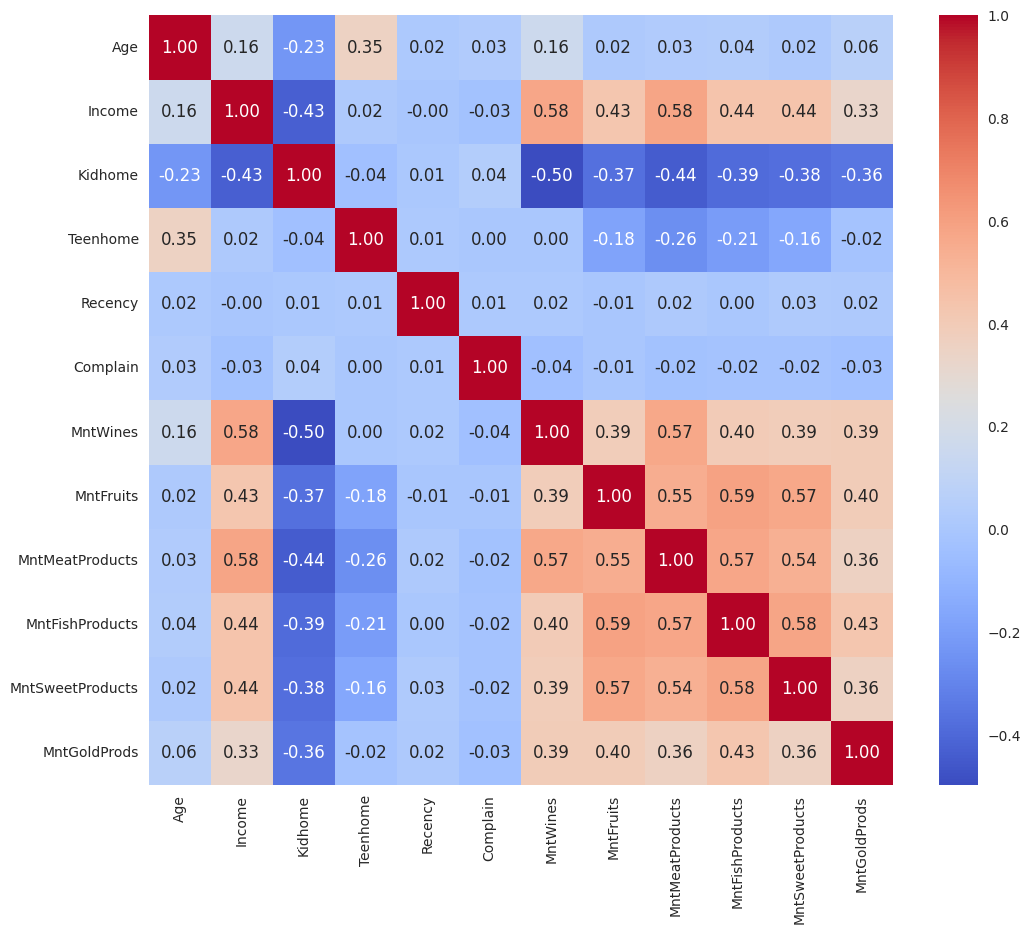

In [111]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm' ,fmt=".2f")
plt.show()

### Cleaning data

In [112]:
data_clean = df.copy()

print("clean before row count: ",len(data_clean))
data_clean['Dt_Customer'] = pd.to_datetime(data_clean.Dt_Customer, format="%d-%m-%Y")
latest_date = data_clean['Dt_Customer'].max()
data_clean['CustomerDays'] = (latest_date - data_clean['Dt_Customer']).dt.days

data_clean['Education'] = data_clean['Education'].replace(['PhD', '2n Cycle', 'Graduation', 'Master'], 'PG')
data_clean['Education'] = data_clean['Education'].replace(['Basic'], 'UG')
data_clean['Marital_Status'] = data_clean['Marital_Status'].replace(['Married', 'Together'],'relationship')
data_clean['Marital_Status'] = data_clean['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')

data_clean['Kids'] = data_clean['Kidhome'] + data_clean['Teenhome']
data_clean['TotalAmount'] = data_clean['MntWines'] + data_clean['MntFruits'] + data_clean['MntMeatProducts'] + data_clean['MntFishProducts'] + data_clean['MntSweetProducts'] + data_clean['MntGoldProds']
data_clean['TotalAcceptedCmp'] = data_clean['AcceptedCmp1'] + data_clean['AcceptedCmp2'] + data_clean['AcceptedCmp3'] + data_clean['AcceptedCmp4'] + data_clean['AcceptedCmp5']
data_clean['TotalNumPurchases'] = data_clean['NumWebPurchases'] + data_clean['NumCatalogPurchases'] + data_clean['NumStorePurchases'] + data_clean['NumDealsPurchases']

data_clean = data_clean[data_clean["Age"]<90]
data_clean = data_clean[data_clean["Income"]<400000]
print("clean after row count: ",len(data_clean))

sel_columns = ['Education', 'Marital_Status', 'Income', 'Kids', 
         'CustomerDays', 'Recency', 'TotalAmount', 'TotalNumPurchases', 
         'TotalAcceptedCmp', 'Complain', 'Response']

data_clean = data_clean[sel_columns]
data_clean.head()

clean before row count:  2216
clean after row count:  2212


,Education,Marital_Status,Income,Kids,CustomerDays,Recency,TotalAmount,TotalNumPurchases,TotalAcceptedCmp,Complain,Response
0,PG,Single,58138.0,0,663,58,1617,25,0,0,1
1,PG,Single,46344.0,2,113,38,27,6,0,0,0
2,PG,relationship,71613.0,0,312,26,776,21,0,0,0
3,PG,relationship,26646.0,1,139,26,53,8,0,0,0
4,PG,relationship,58293.0,1,161,94,422,19,0,0,0


# Model building and training

In [113]:
# print the list of categorical columns
print(list(data_clean.select_dtypes(include=["object"]).columns))

# label encoding for the categorical columns
LE = LabelEncoder()
# encoding the categorical columns
for col in data_clean:
    if data_clean[col].dtype == 'object':
        data_clean[col] = LE.fit_transform(data_clean[col])

#Creating a copy of data
ds = data_clean.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

#Scaling
scaler = StandardScaler().fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds), columns = ds.columns)

['Education', 'Marital_Status']


### Model 1：K-Means

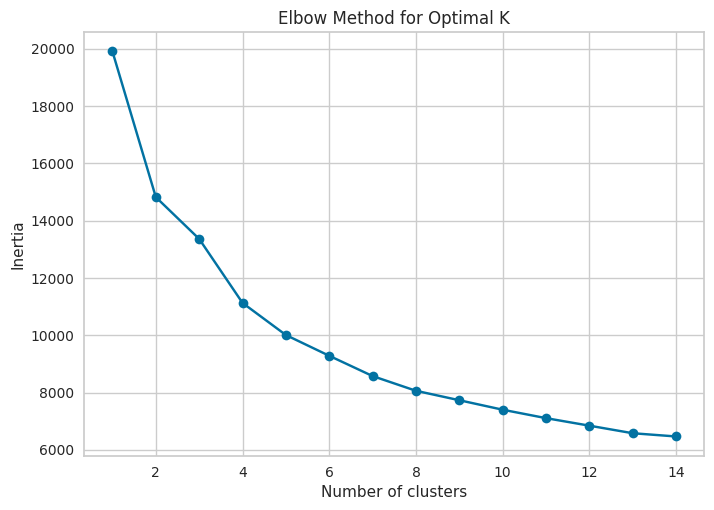

In [114]:
# 肘部法则确定K值
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_ds)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 15, 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

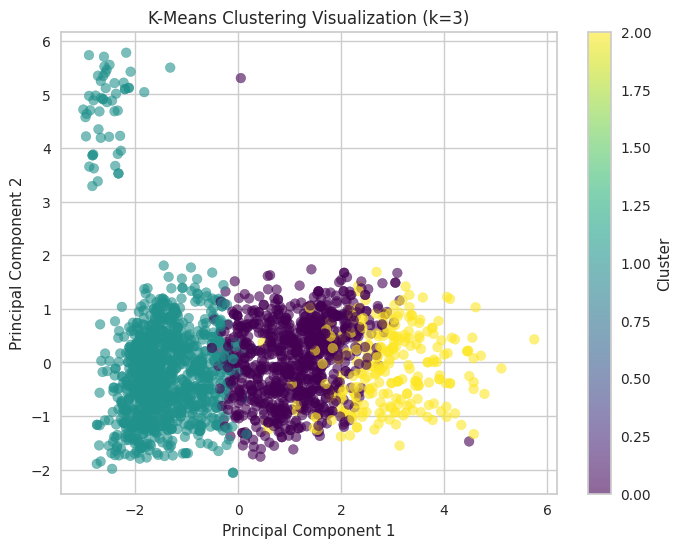

K-Means score：0.310


In [115]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scaled_ds)

pca = PCA(n_components=3)
data_pca = pca.fit_transform(scaled_ds)

plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering Visualization (k=3)")
plt.colorbar(label="Cluster")
plt.show()

print(f"K-Means score：{silhouette_score(data_pca, kmeans_labels):.3f}")

### Model 2：DBSCAN

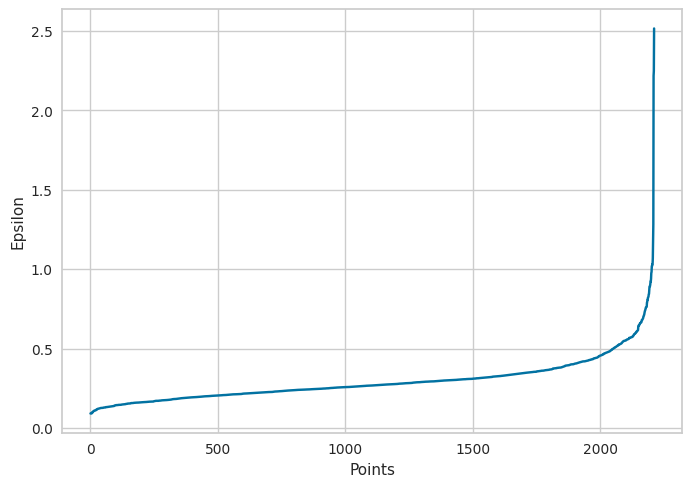

In [116]:
# The K-Distance curve was used to find the best eps
nn = NearestNeighbors(n_neighbors=5).fit(data_pca)
distances, _ = nn.kneighbors(data_pca)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Epsilon')
plt.show()

In [117]:
# Parameter search
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_pca)
print(f"DBSCAN labels：{len(np.unique(dbscan_labels))-1}")
print(f"DBSCAN score：{silhouette_score(data_pca, dbscan_labels):.3f}")

DBSCAN labels：3
DBSCAN score：0.361


# Hyperparameter Tuning（K-Means）

In [118]:
silhouette_scorer = make_scorer(silhouette_score)

pipeline = Pipeline([  
    ('pca', PCA(n_components=3)),
    ('kmeans', KMeans())  
])  

param_grid = {  
    'kmeans__n_clusters': [3,4,5],  
    'kmeans__init': ['k-means++', 'random'],  
    'pca__n_components': [2,3]  
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=silhouette_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

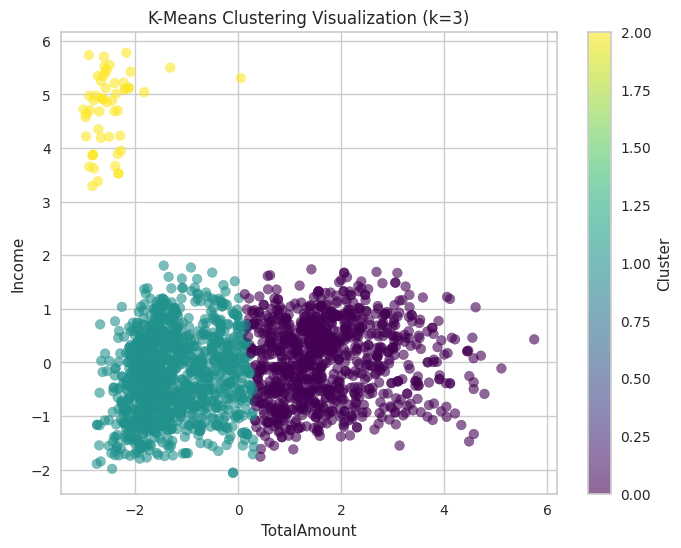

K-Means score：0.445


In [119]:
# choose K=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_pca)

pca = PCA(n_components=3).fit(scaled_ds)
data_pca = pd.DataFrame(pca.transform(scaled_ds), columns=(["TotalAmount", "Income", "TotalNumPurchases"]))
data_pca.describe().T

# Plot using column names
plt.figure(figsize=(8, 6))
plt.scatter(data_pca["TotalAmount"], data_pca["Income"], c=kmeans_labels, cmap="viridis", alpha=0.6)
plt.xlabel("TotalAmount")
plt.ylabel("Income")
plt.title("K-Means Clustering Visualization (k=3)")
plt.colorbar(label="Cluster")
plt.show()

print(f"K-Means score：{silhouette_score(data_pca, kmeans_labels):.3f}")

### Visual comparison

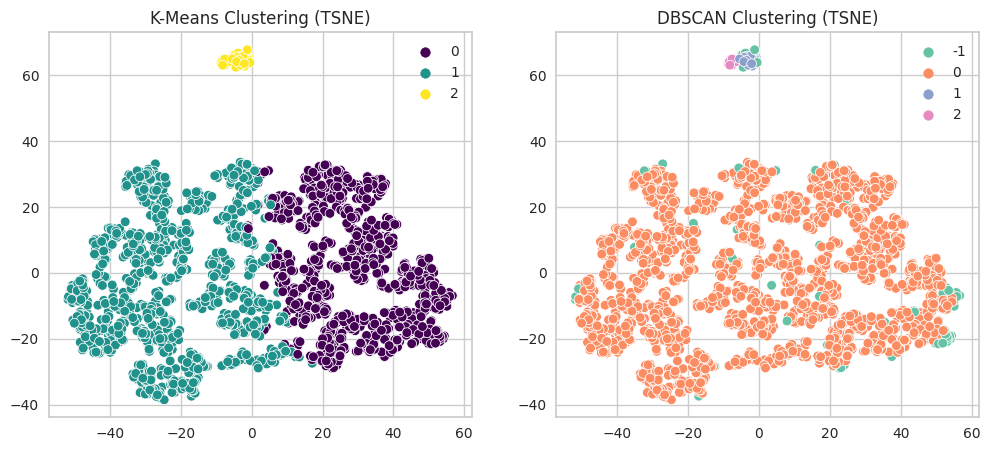

In [120]:
# Visual comparison
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(data_pca)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans_labels, palette='viridis')
plt.title('K-Means Clustering (TSNE)')

plt.subplot(1,2,2)
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=dbscan_labels, palette='Set2')
plt.title('DBSCAN Clustering (TSNE)')
plt.show()

K-Means silhouette score after tuning：0.445
DBSCAN silhouette score：0.361


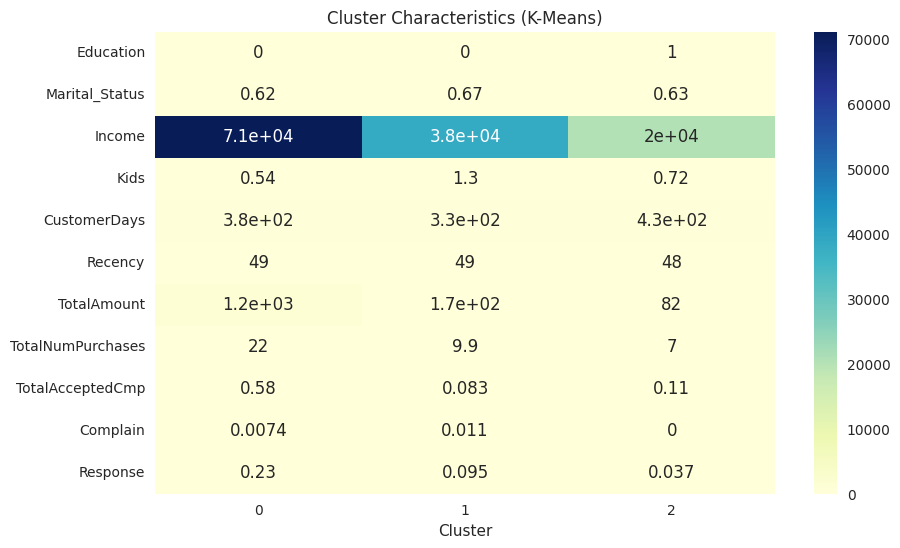

In [121]:
# Evaluation metrics
print(f"K-Means silhouette score after tuning：{silhouette_score(data_pca, kmeans_labels):.3f}")
print(f"DBSCAN silhouette score：{silhouette_score(data_pca, dbscan_labels):.3f}")

# Feature analysis
cluster_profile = data_clean.copy()
cluster_profile['Cluster'] = kmeans_labels

plt.figure(figsize=(10,6))
cluster_mean = cluster_profile.groupby('Cluster')[sel_columns].mean()
sns.heatmap(cluster_mean.T, annot=True, cmap='YlGnBu')
plt.title('Cluster Characteristics (K-Means)')
plt.show()

# Analyze the results

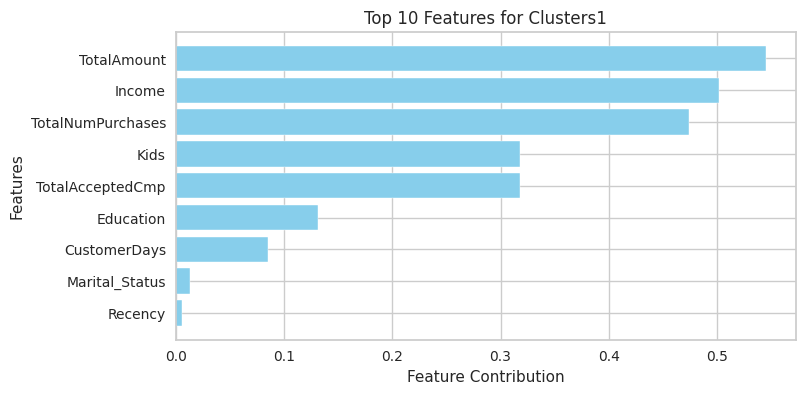

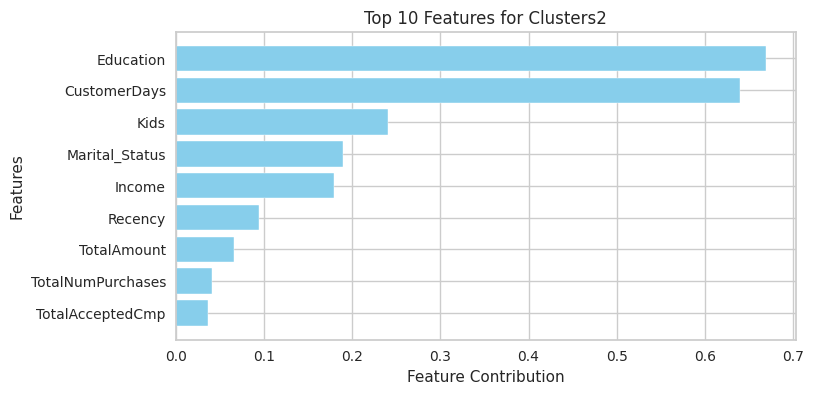

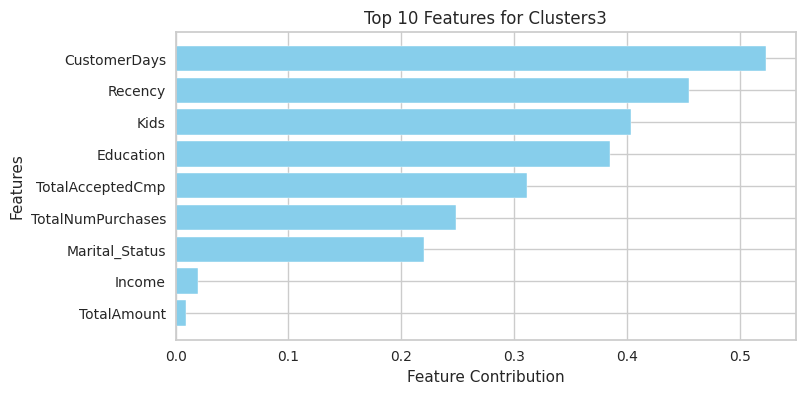

In [122]:
top_n = 10

feature_importance = np.abs(pca.components_)

for i in range(min(5, len(pca.components_))): 
    sorted_indices = np.argsort(feature_importance[i])[::-1]  
    top_features = [data_clean.columns[idx] for idx in sorted_indices[:top_n]]
    top_values = feature_importance[i][sorted_indices[:top_n]]

    plt.figure(figsize=(8, 4))
    plt.barh(top_features[::-1], top_values[::-1], color="skyblue")  
    plt.xlabel("Feature Contribution")
    plt.ylabel("Features")
    plt.title(f"Top {top_n} Features for Clusters{i+1}")
    plt.show()

#### K-Means Customer Segmentation Analysis:

- **Moderate Income, Moderate Spending**: Customers in this cluster have a balanced level of income and spending, displaying a stable consumption pattern. This is the largest group, representing the typical spending behavior among customers.  
- **Low Income, Low Spending**: This cluster represents customers with low income and low spending, possibly due to financial constraints. They are likely to be more conservative in their spending.  
- **High Income, Low Spending**: These customers have high income but low spending. They may prioritize saving over spending or adopt a cautious approach to expenditures relative to their income.

# Conclusion

### Key Takeaways
- EDA helped uncover major customer spending patterns.
- Comparison of different clustering methods showed that the optimized K-Means performed best in this project.
- PCA improved computational efficiency and clustering quality.

### Future Improvements
- Explore more advanced clustering algorithms such as Gaussian Mixture Model (GMM) or hierarchical clustering.
- Enhance feature engineering to discover more variables influencing consumption behavior.
- Combine with supervised learning methods to further refine customer profiling.

The findings of this project provide valuable insights for marketing strategies, helping businesses better target their customers.